In [1]:
# Numpy.
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

# Need plots.
import matplotlib.pyplot as plt

# Pandas.
import pandas as pd

# Machine learning toolkit.
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

# Scipy for fft's and the like.
import scipy as sc
import scipy.io.wavfile as wavfile
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy import stats

# Seaborn for plots.
import seaborn as sns

# Ipython for basic visual output types.
import IPython

# Imbalanced learn for rebalancing.
from imblearn.over_sampling import SMOTE

# Standard Python libs.
import os
import glob
import csv
from dataclasses import dataclass

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For images
from skimage.color import rgb2gray
import cv2
from scipy import ndimage

In [2]:
df = pd.read_csv('/Users/gpanirudh/Downloads/Academics/UTK/Semester-1/COSC530_Machine-Learning/Final-Project/data/cat_dogs/annotations/annotations/list.txt')

info = df.head(4).copy()
df = df.loc[5:,]

df[['CLASS-ID','SPECIES','BREED','ID']] = df['#Image CLASS-ID SPECIES BREED ID'].str.split(expand=True) 

df = df.drop('#Image CLASS-ID SPECIES BREED ID',axis=1)
df = df.rename(columns={"CLASS-ID": "image", "SPECIES": "CLASS-ID", 'BREED' : "SPECIES", "ID":"BREED ID"})

df[["CLASS-ID","SPECIES","BREED ID"]] = df[["CLASS-ID","SPECIES","BREED ID"]].astype(int)

df= df[df['SPECIES']==1] #cats

df['image'] = df['image'].apply(lambda x : str(x)+'.jpg')
df = df[['image','BREED ID']]

df = df.reset_index()
df = df.drop('index',axis=1)

df['BREED ID'] = df['BREED ID'].astype('str')

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    validation_split=0.2,
                                    rotation_range=90,
                                    width_shift_range=0.2, 
                                   height_shift_range=0.2)


validation_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255)

In [4]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/Users/gpanirudh/Downloads/Academics/UTK/Semester-1/COSC530_Machine-Learning/Final-Project/data/cat_dogs/images/images/',
        x_col='image',
        y_col='BREED ID',
        target_size=(350, 350),
        batch_size=64,
        class_mode="categorical",
        seed=123,
        #validate_filenames = False,
        subset='training'
)

valid_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/Users/gpanirudh/Downloads/Academics/UTK/Semester-1/COSC530_Machine-Learning/Final-Project/data/cat_dogs/images/images/',
        x_col='image',
        y_col='BREED ID',
        target_size=(350, 350),
        batch_size=64,
        class_mode="categorical",
        seed=123,
        #validate_filenames = False,
        subset='validation')

Found 1897 validated image filenames belonging to 12 classes.
Found 474 validated image filenames belonging to 12 classes.


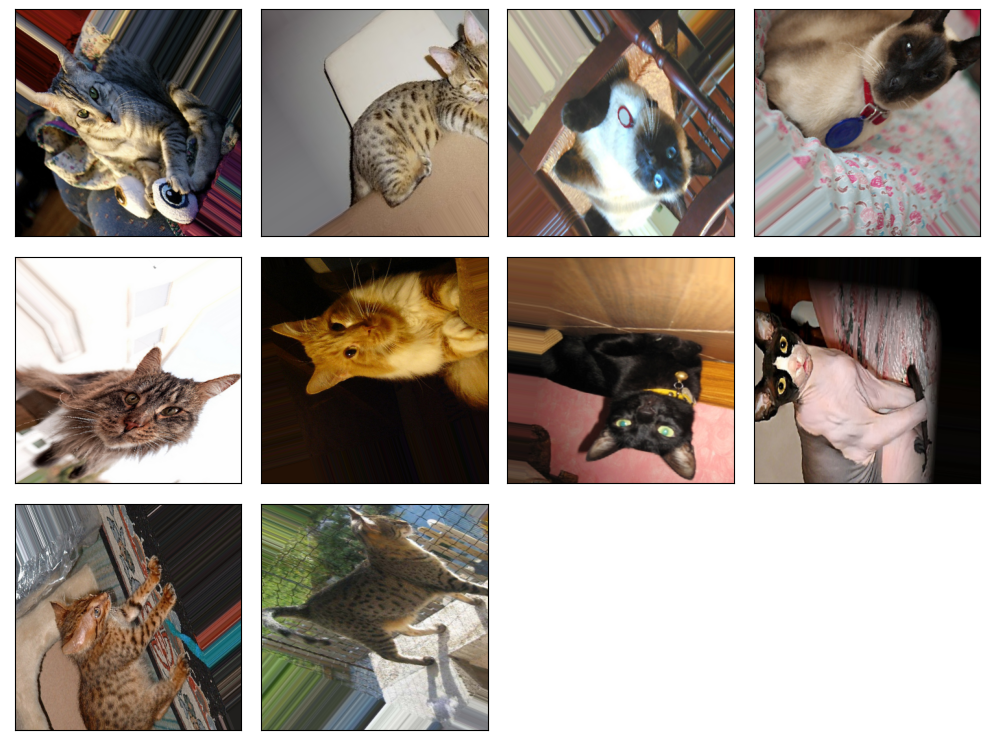

In [5]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

# Segmentation

## Region based Segmentation

One simple way to segment different objects could be to use their pixel values. An important point to note – the pixel values will be different for the objects and the image’s background if there’s a sharp contrast between them.

In this case, we can set a threshold value. The pixel values falling below or above that threshold can be classified accordingly (as an object or the background). This technique is known as Threshold Segmentation.

If we want to divide the image into two regions (object and background), we define a single threshold value. This is known as the global threshold.

If we have multiple objects along with the background, we must define multiple thresholds. These thresholds are collectively known as the local threshold.

(400, 600, 3)


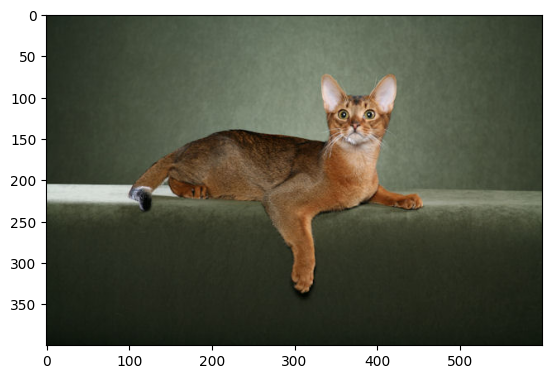

In [7]:
image  = plt.imread('/Users/gpanirudh/Downloads/Academics/UTK/Semester-1/COSC530_Machine-Learning/Final-Project/data/cat_dogs/images/images/Abyssinian_1.jpg')
print(image.shape)
plt.imshow(image)

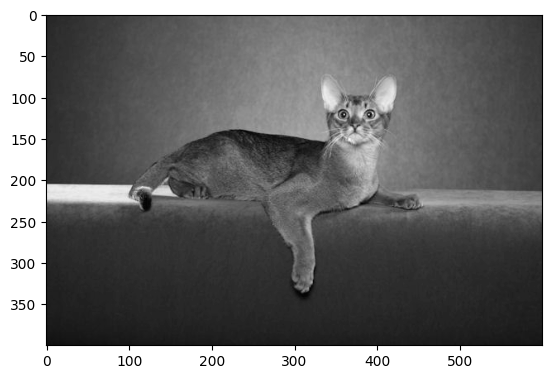

In [8]:
gray = rgb2gray(image)
plt.imshow(gray, cmap='gray')

The height and width of the image is 400 and 600 respectively. We will take the mean of the pixel values and use that as a threshold. If the pixel value is more than our threshold, we can say that it belongs to an object. If the pixel value is less than the threshold, it will be treated as the background.

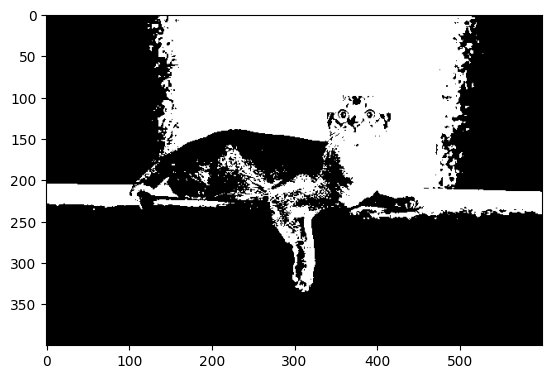

In [11]:
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

The darker region (black) represents the background and the brighter (white) region is the foreground. We can define multiple thresholds as well to detect multiple objects:

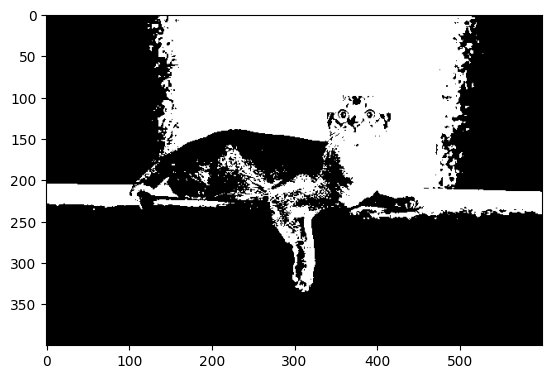

In [12]:
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 3
    elif gray_r[i] > 0.5:
        gray_r[i] = 2
    elif gray_r[i] > 0.25:
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')


There are four different segments in the above image. Some of the advantages of this method are: Calculations are simpler, Fast operation speed, When the object and background have high contrast, this method performs really well.

But there are some limitations to this approach. When we don’t have significant grayscale difference, or there is an overlap of the grayscale pixel values, it becomes very difficult to get accurate segments.

## Edge Detection Segmentation

What divides two objects in an image? There is always an edge between two adjacent regions with different grayscale values (pixel values). The edges can be considered as the discontinuous local features of an image.

We can make use of this discontinuity to detect edges and hence define a boundary of the object. This helps us in detecting the shapes of multiple objects present in a given image. To detect edges, we will use filters and convolutions. Choosing some specific values for these weight matrices helps us to detect horizontal or vertical edges (or even the combination of horizontal and vertical edges).

One such weight matrix is the sobel operator. It is typically used to detect edges. The sobel operator has two weight matrices – one for detecting horizontal edges and the other for detecting vertical edges.

Sobel filter (horizontal) =

[1 2 1

0 0 0

-1 -2 -1]

Sobel filter (vertical) =

[-1 0 1

-2 0 2

-1 0 1]

(400, 600, 3)


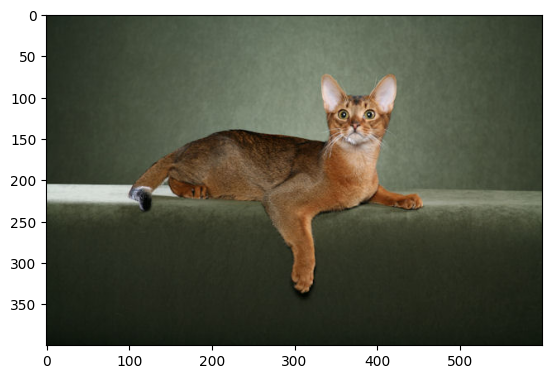

In [21]:
image = plt.imread('/Users/gpanirudh/Downloads/Academics/UTK/Semester-1/COSC530_Machine-Learning/Final-Project/data/cat_dogs/images/images/Abyssinian_1.jpg')
print(image.shape)
plt.imshow(image)

In [14]:
# converting to grayscale
gray = rgb2gray(image)

# defining the sobel filters
sobel_horizontal = np.array([np.array([1, 2, 1]), np.array([0, 0, 0]), np.array([-1, -2, -1])])
print(sobel_horizontal, 'is a kernel for detecting horizontal edges')
print()
sobel_vertical = np.array([np.array([-1, 0, 1]), np.array([-2, 0, 2]), np.array([-1, 0, 1])])
print(sobel_vertical, 'is a kernel for detecting vertical edges')

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]] is a kernel for detecting horizontal edges

[[-1  0  1]
 [-2  0  2]
 [-1  0  1]] is a kernel for detecting vertical edges


In [16]:
out_h = ndimage.convolve(gray, sobel_horizontal, mode='reflect')
out_v = ndimage.convolve(gray, sobel_vertical, mode='reflect')
# here mode determines how the input array is extended when the filter overlaps a border.

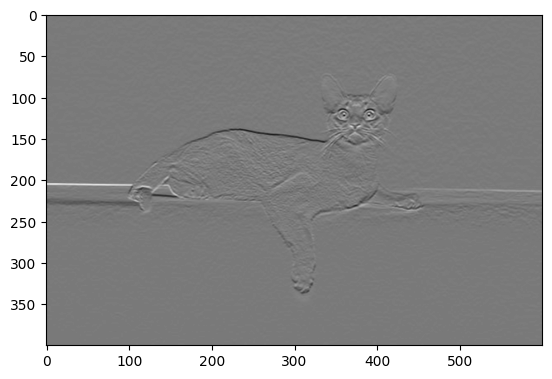

In [17]:
plt.imshow(out_h, cmap='gray')

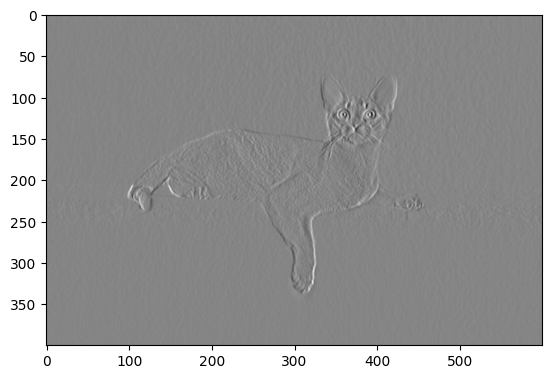

In [18]:
plt.imshow(out_v, cmap='gray')

Here, we are able to identify the horizontal as well as the vertical edges. There is one more type of filter that can detect both horizontal and vertical edges at the same time. This is called the laplace operator:

[1 1 1

1 -8 1

1 1 1]

In [19]:
kernel_laplace = np.array([np.array([1, 1, 1]), np.array([1, -8, 1]), np.array([1, 1, 1])])
print(kernel_laplace, 'is a laplacian kernel')

[[ 1  1  1]
 [ 1 -8  1]
 [ 1  1  1]] is a laplacian kernel


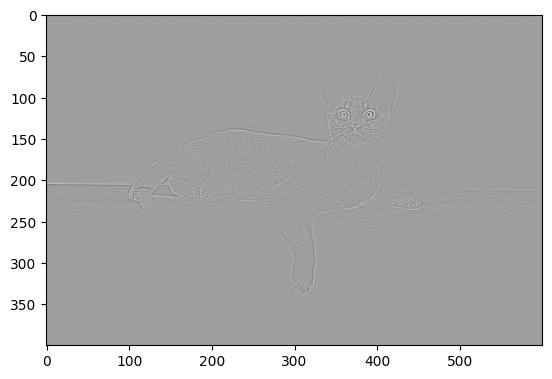

In [20]:
out_l = ndimage.convolve(gray, kernel_laplace, mode='reflect')
plt.imshow(out_l, cmap='gray')

## Image Segmentation - Color Clustering

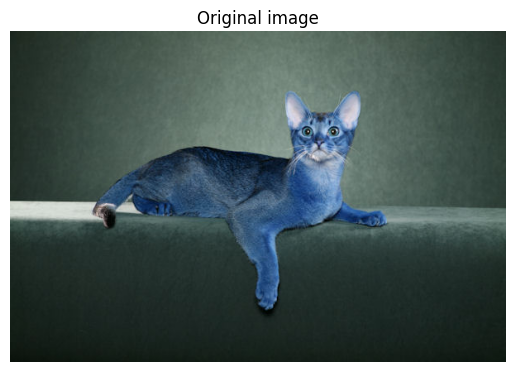

In [42]:
image1='/Users/gpanirudh/Downloads/Academics/UTK/Semester-1/COSC530_Machine-Learning/Final-Project/data/cat_dogs/images/images/Abyssinian_1.jpg'
image=cv2.imread(image1)
plt.axis('off')
plt.imshow(image)
plt.title('Original image')
plt.show()

According to wikipedia the R, G, and B components of an object’s color in a digital image are all correlated with the amount of light hitting the object, and therefore with each other, image descriptions in terms of those components make object discrimination difficult. Descriptions in terms of hue/lightness/chroma or hue/lightness/saturation are often more relevant.

So, we need to convert our image from RGB Colours Space to HSV to work ahead.

In [43]:
img=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

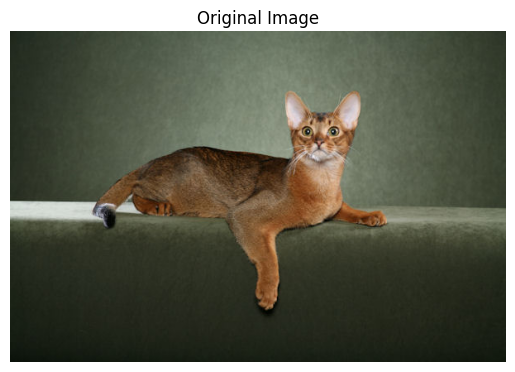

In [44]:
plt.axis('off')
plt.imshow(img)
plt.title('Original Image')
plt.show()

In [45]:
img.shape

(400, 600, 3)

Now, convert the (400, 600, 3) image to (240000, 3) (m*n) which will not be a vector in the 3-D space of RGB. Also, converting it to float value.

In [46]:
vectorized = np.float32(img.reshape((-1,3)))
vectorized.shape

(240000, 3)

In [47]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)

Applying k-Means clustering on the image:

In [66]:
K = 4
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [67]:
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))

result_image is the output result. Lets see how the image looks after k-means clustering

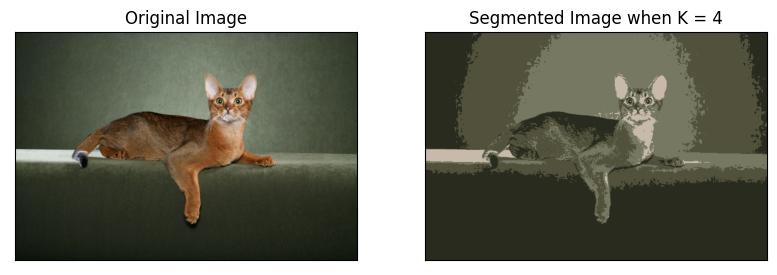

In [68]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(2,3,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

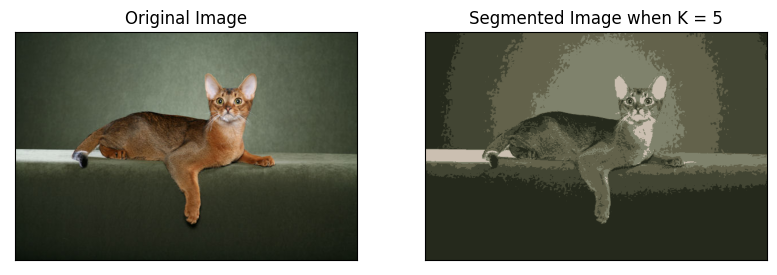

In [69]:
K = 5
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(2,3,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

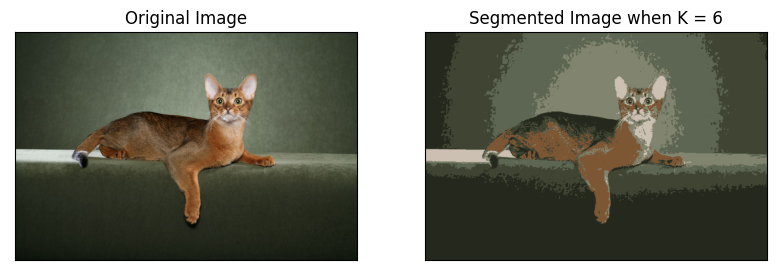

In [70]:
K = 6
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(2,3,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

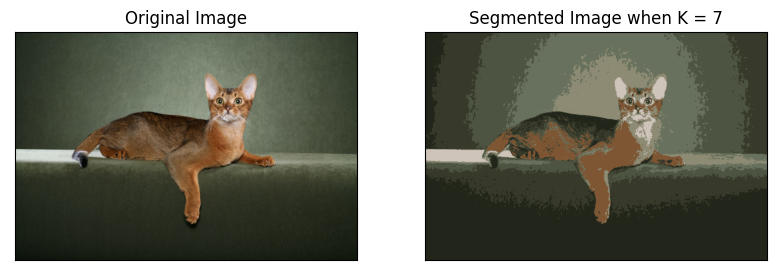

In [71]:
K = 7
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(2,3,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

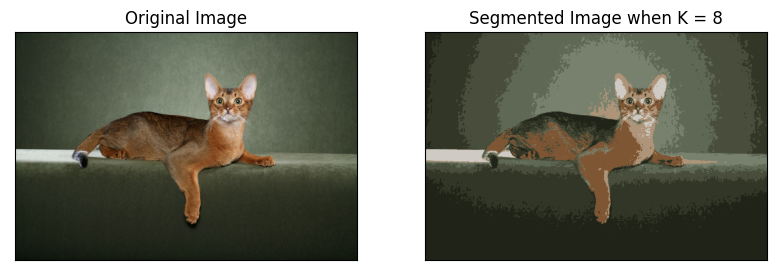

In [72]:
K = 8
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(2,3,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

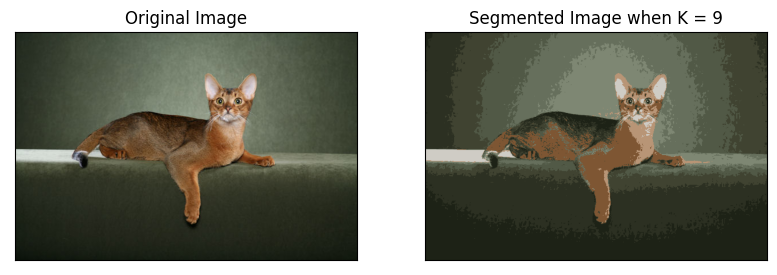

In [73]:
K = 9
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(2,3,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

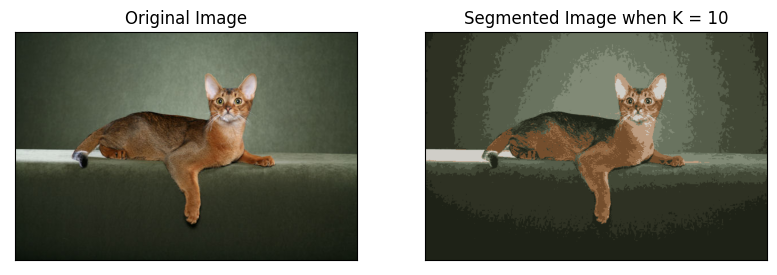

In [74]:
K = 10
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(2,3,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

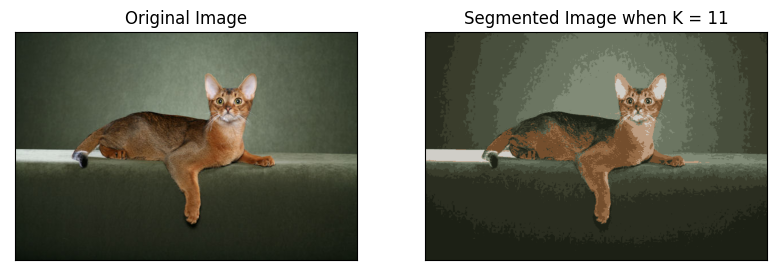

In [75]:
K = 11
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(2,3,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

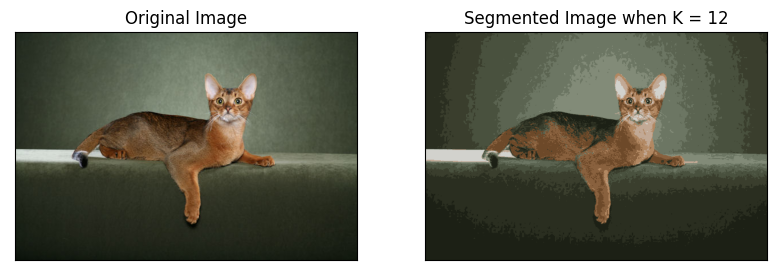

In [76]:
K = 12
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(2,3,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

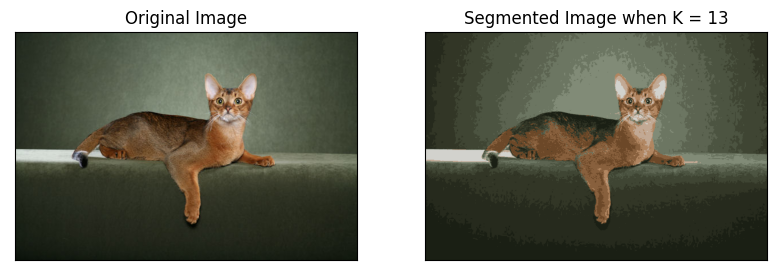

In [77]:
K = 13
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(2,3,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

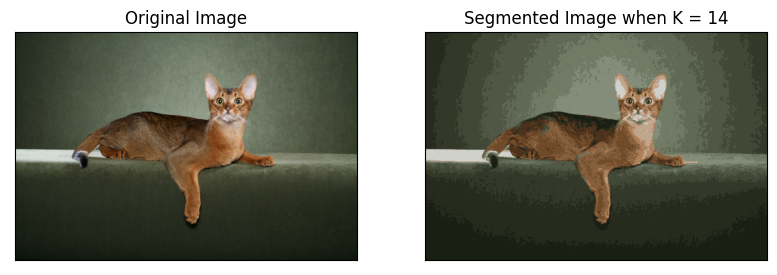

In [78]:
K = 14
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(2,3,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

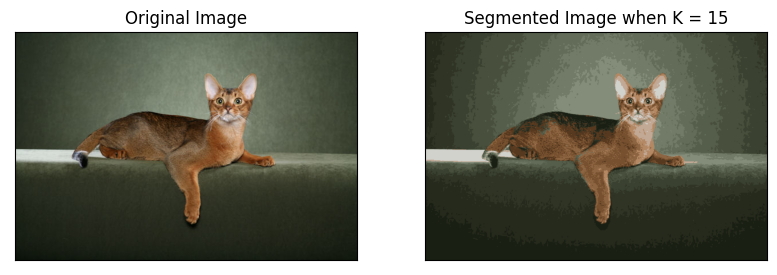

In [79]:
K = 15
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(2,3,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

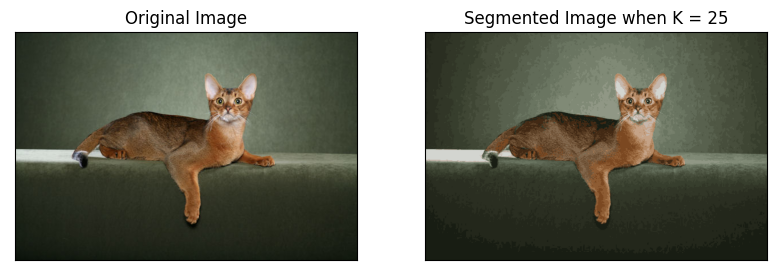

In [80]:
K = 25
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(2,3,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()